Coordinate Reference System (CRS): EPSG:32720
Coordinate Range (Bounding Box):
  Min Longitude (West): 845580.0
  Max Longitude (East): 847160.0
  Min Latitude (South): 9329240.0
  Max Latitude (North): 9331190.0


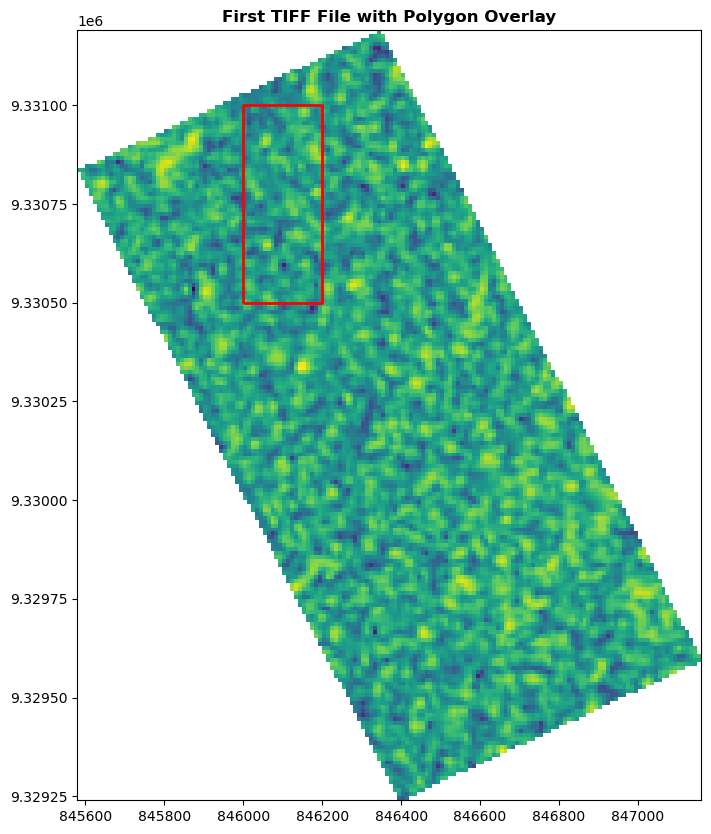

In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import Polygon
from sklearn.preprocessing import StandardScaler
import joblib
from datetime import datetime
import sys
from rasterio.plot import show

# Step 1: Load Time Series Data
time_series_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\time_series"

# Get the list of all TIFF files in the directory sorted by date
tif_files = sorted([f for f in os.listdir(time_series_dir) if f.endswith('.tif')])

# Load a sample TIFF file to extract coordinate bounds
sample_tif_path = os.path.join(time_series_dir, tif_files[0])

# Step 2: Determine the Coordinate Range
with rasterio.open(sample_tif_path) as src:
    bounds = src.bounds
    crs = src.crs

# Print the coordinate range
print(f"Coordinate Reference System (CRS): {crs}")
print(f"Coordinate Range (Bounding Box):")
print(f"  Min Longitude (West): {bounds.left}")
print(f"  Max Longitude (East): {bounds.right}")
print(f"  Min Latitude (South): {bounds.bottom}")
print(f"  Max Latitude (North): {bounds.top}")

# Step 3: Define the Polygon
polygon_coords = [
    (846000.0, 9330500.0),  # Bottom-left corner
    (846000.0, 9331000.0),  # Top-left corner
    (846200.0, 9331000.0),  # Top-right corner
    (846200.0, 9330500.0)   # Bottom-right corner
]

# Create the Polygon object
polygon = Polygon(polygon_coords)

# Convert to GeoDataFrame (necessary for rasterio mask function)
gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=crs)

# Step 4: Plot the First TIFF File with the Polygon Overlaid
def plot_tif_with_polygon(tif_path, polygon_gdf):
    with rasterio.open(tif_path) as src:
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Plot the TIFF image (first band for visualization)
        show(src, ax=ax, title="First TIFF File with Polygon Overlay")

        # Plot the polygon on top
        polygon_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

        # Set the extent of the plot to the bounds of the image
        ax.set_xlim(src.bounds.left, src.bounds.right)
        ax.set_ylim(src.bounds.bottom, src.bounds.top)

        plt.show()

# Plot the first TIFF file with the polygon
plot_tif_with_polygon(os.path.join(time_series_dir, tif_files[0]), gdf)

# Step 5: Load the Model and Scaler
model_path = r'D:\Development\RESEARCH\MarvinBlue\Results\rf_model_tile.pkl'  # or 'svm_model_tile.pkl'
forest_classifier = joblib.load(model_path)

scaler_path = r'D:\Development\RESEARCH\MarvinBlue\Results\scaler_tile.pkl'
scaler = joblib.load(scaler_path)

# Step 6: Define the Feature Extraction Function
def extract_tile_features(band, i, j, window_size=1):
    """Extract features from a 3x3 tile around the pixel at (i, j) in the band, ensuring no NaNs in the tile."""
    tile = band[max(0, i-window_size):i+window_size+1, max(0, j-window_size):j+window_size+1]
    if np.isnan(tile).any():
        return None  # Skip tiles with NaN values
    mean_val = np.nanmean(tile)
    std_val = np.nanstd(tile)
    min_val = np.nanmin(tile)
    max_val = np.nanmax(tile)
    return mean_val, std_val, min_val, max_val

# def extract_features(image_data):
#     """Extract features from the first two bands (VV, VH)."""
#     band1, band2 = image_data[0], image_data[1]
#     h, w = band1.shape
#     features = []

#     for i in range(h):
#         for j in range(w):
#             band1_features = extract_tile_features(band1, i, j)
#             band2_features = extract_tile_features(band2, i, j)
#             if band1_features and band2_features:
#                 features.append(band1_features + band2_features)
    
#     return np.array(features)


def extract_features(image_data):
    """Extract features from the first two bands (VV, VH) and include ratios to the band 3 mean, excluding NaN-containing tiles."""
    band1, band2, band3 = image_data[0], image_data[1], image_data[2]
    h, w = band1.shape
    features = []

    for i in range(h):
        for j in range(w):
            band1_features = extract_tile_features(band1, i, j)
            band2_features = extract_tile_features(band2, i, j)
            if band1_features and band2_features:  # Only add features if neither are None
                band3_mean = np.nanmean(band3[max(0, i-1):i+2, max(0, j-1):j+2])
                if not np.isnan(band3_mean):
                    band1_ratio = band1[i, j] / band3_mean
                    band2_ratio = band2[i, j] / band3_mean
                    features.append(band1_features + band2_features + (band1_ratio, band2_ratio))
    
    return np.array(features)




# Step 7: Define the Deforestation Detection Function
def is_deforested_rate_of_change(previous_percentage, current_percentage, rate_threshold=10):
    """Check if the rate of increase in non-forest percentage exceeds the threshold."""
    rate_of_change = current_percentage - previous_percentage
    return rate_of_change > rate_threshold

def smooth_data(data, window_size=5):
    """Apply a moving average to the data to smooth out short-term fluctuations."""
    return pd.Series(data).rolling(window=window_size).mean()

def is_deforested_moving_average(smoothed_percentage, threshold=50):
    """Check if the smoothed non-forest percentage exceeds the threshold."""
    return smoothed_percentage > threshold

def calculate_baseline(non_forest_summary, baseline_period):
    """Calculate the baseline non-forest percentage during a stable period."""
    baseline_values = [percentage for date, percentage in non_forest_summary if baseline_period[0] <= date <= baseline_period[1]]
    return np.mean(baseline_values)

def is_deforested_baseline(current_percentage, baseline, margin=20):
    """Check if the current percentage is significantly above the baseline."""
    return current_percentage > (baseline + margin)

def is_deforested_combination(previous_percentage, current_percentage, baseline, threshold=50, rate_threshold=10):
    """Combine rate of change and absolute threshold criteria to define deforestation."""
    rate_of_change = current_percentage - previous_percentage
    exceeds_threshold = current_percentage > (baseline + threshold)
    print(f"Rate of Change: {rate_of_change}, Exceeds Threshold: {exceeds_threshold}")
    return (rate_of_change > rate_threshold) and exceeds_threshold

def check_temporal_consistency(non_forest_summary, window_size=3, threshold=50):
    """Check if there's a consistent increase in non-forest percentage over multiple time steps."""
    smoothed_data = smooth_data([percentage for _, percentage in non_forest_summary], window_size)
    return all(x > threshold for x in smoothed_data[-window_size:])

def extract_date_from_filename(filename):
    """Extract the date from the filename, assuming the date is in a specific position."""
    date_str = filename.split('_')[4]  # Adjust based on your file name pattern
    return datetime.strptime(date_str, "%Y%m%dT%H%M%S").date()

def classify_and_detect_deforestation(polygon_gdf, tif_files, method='combination'):
    # Sort the files by date before processing
    tif_files = sorted(tif_files, key=extract_date_from_filename)
    
    previous_classification = None
    total_files = len(tif_files)
    non_forest_summary = []
    initial_predictions = None  # To store the initial prediction map
    initial_file_date = None
    final_predictions = None  # To store the final prediction map
    final_file_date = None
    deforestation_detected = False  # Track if deforestation has been detected
    deforestation_date = None  # To store the date of deforestation detection

    baseline_period = [datetime(2015, 1, 1).date(), datetime(2016, 1, 1).date()]  # Define your stable period here

    for index, tif_file in enumerate(tif_files):
        sys.stdout.write(f"\rProcessing file {index + 1} out of {total_files}...")
        sys.stdout.flush()

        tif_path = os.path.join(time_series_dir, tif_file)
        with rasterio.open(tif_path) as src:
            out_image, out_transform = mask(src, polygon_gdf.geometry, crop=True)
            out_image = out_image.astype(np.float32)
            out_image = np.nan_to_num(out_image, nan=-9999)

            h, w = out_image.shape[1], out_image.shape[2]
            valid_features = []

            for i in range(h):
                for j in range(w):
                    tile_features = extract_features(out_image[:, i:i+1, j:j+1])
                    if tile_features is not None:
                        valid_features.append(tile_features)

            if not valid_features:
                continue

            # Convert list of features into a 2D numpy array
            valid_features = np.vstack(valid_features)

            # Normalize the features using the scaler
            valid_features_normalized = scaler.transform(valid_features)

            # Classify the pixels using the loaded model
            predictions = forest_classifier.predict(valid_features_normalized).reshape(h, w)

            # Store the initial prediction map and date
            if initial_predictions is None:
                initial_predictions = predictions
                initial_file_date = extract_date_from_filename(tif_file)

            # Always update the final predictions and date
            final_predictions = predictions
            final_file_date = extract_date_from_filename(tif_file)

            # Calculate the number of non-forest pixels and the percentage
            non_forest_pixels = np.sum(predictions == 0)
            total_pixels = predictions.size
            non_forest_percentage = (non_forest_pixels / total_pixels) * 100

            # Store the summary data
            non_forest_summary.append((final_file_date, non_forest_percentage))

            # Choose the deforestation detection method
            if method == 'rate_of_change':
                if index > 0 and is_deforested_rate_of_change(non_forest_summary[index-1][1], non_forest_percentage):
                    deforestation_detected = True
                    deforestation_date = final_file_date
            elif method == 'moving_average':
                if len(non_forest_summary) >= 5:  # Ensure there are enough data points for smoothing
                    smoothed_percentages = smooth_data([percent for _, percent in non_forest_summary])
                    smoothed_percentage = smoothed_percentages.iloc[-1] if len(smoothed_percentages) > 0 else None
                    if smoothed_percentage is not None and is_deforested_moving_average(smoothed_percentage):
                        deforestation_detected = True
                        deforestation_date = final_file_date
            elif method == 'baseline':
                baseline = calculate_baseline(non_forest_summary, baseline_period)
                if is_deforested_baseline(non_forest_percentage, baseline):
                    deforestation_detected = True
                    deforestation_date = final_file_date
            elif method == 'combination':
                if index > 0:
                    baseline = calculate_baseline(non_forest_summary, baseline_period)
                    if is_deforested_combination(non_forest_summary[index-1][1], non_forest_percentage, baseline):
                        deforestation_detected = True
                        deforestation_date = final_file_date
            elif method == 'temporal_consistency':
                if check_temporal_consistency(non_forest_summary):
                    deforestation_detected = True
                    deforestation_date = final_file_date

            previous_classification = predictions

    # Plot the initial and final predictions only once
    if initial_predictions is not None and final_predictions is not None:
        visualize_predictions(initial_predictions, initial_file_date, final_predictions, final_file_date, out_transform)
        visualize_change_groups(initial_predictions, final_predictions, initial_file_date, final_file_date, out_transform)

    # Plot the summary and include the deforestation detection date
    plot_non_forest_percentage(non_forest_summary, tif_files, deforestation_date)

    if deforestation_detected:
        print(f"\nDeforestation detected on: {deforestation_date}")
    else:
        print("\nNo significant deforestation detected in the given time series.")

def plot_non_forest_percentage(non_forest_summary, tif_files, deforestation_date=None):
    """Plot the non-forest percentage over time with custom point colors based on file name prefix and mark deforestation detection date."""
    dates, percentages = zip(*non_forest_summary)

    # Create a color map for the points based on the file name prefix
    colors = []
    for tif_file in tif_files:
        if tif_file.startswith('S1A'):
            colors.append('green')
        elif tif_file.startswith('S1B'):
            colors.append('red')
        else:
            colors.append('blue')  # Default color if neither S1A nor S1B

    plt.figure(figsize=(14, 7))
    plt.plot(dates, percentages, linestyle='-', color='blue', alpha=0.7, label='Non-Forest %')

    # Plot points with custom colors
    for i, (date, percentage) in enumerate(zip(dates, percentages)):
        plt.scatter(date, percentage, color=colors[i], s=50)  # Adjust 's' for marker size

    # Add a vertical line to mark the deforestation detection date
    if deforestation_date:
        plt.axvline(deforestation_date, color='red', linestyle='--', label=f'Deforestation Detected on {deforestation_date}')

    # Format x-axis dates for better readability
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gcf().autofmt_xdate()

    plt.xlabel('Date')
    plt.ylabel('Non-Forest Percentage (%)')
    plt.title('Non-Forest Percentage Over Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualize_predictions(initial_predictions, initial_file_date, final_predictions, final_file_date, transform):
    """Visualize the initial and final predictions side by side with a binary legend and projection values."""
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Map predictions to colors (forest: green, non-forest: brown)
    cmap = mcolors.ListedColormap(['brown', 'green'])
    
    # Initial map
    im1 = axes[0].imshow(initial_predictions, cmap=cmap, extent=[transform[2], transform[2] + transform[0] * initial_predictions.shape[1],
                                                                 transform[5] + transform[4] * initial_predictions.shape[0], transform[5]])
    axes[0].set_title(f"Initial Predictions on {initial_file_date}")
    axes[0].set_xlabel("X Projection (m)")
    axes[0].set_ylabel("Y Projection (m)")
    axes[0].set_xticks([])  # Remove x-axis ticks for clarity

    # Final map
    im2 = axes[1].imshow(final_predictions, cmap=cmap, extent=[transform[2], transform[2] + transform[0] * final_predictions.shape[1],
                                                               transform[5] + transform[4] * final_predictions.shape[0], transform[5]])
    axes[1].set_title(f"Predictions on {final_file_date}")
    axes[1].set_xlabel("X Projection (m)")
    axes[1].set_ylabel("Y Projection (m)")

    # Create a custom legend
    legend_labels = {0: 'Non-Forest', 1: 'Forest'}
    patches = [plt.matplotlib.patches.Patch(color=cmap(i), label=legend_labels[i]) for i in legend_labels]
    fig.legend(handles=patches, bbox_to_anchor=(0.5, 0), loc='upper center', ncol=2)
    
    plt.tight_layout()
    plt.show()

def visualize_change_groups(initial_predictions, final_predictions, initial_file_date, final_file_date, transform):
    """Visualize the changes in land cover with four groups."""
    
    # Adjust the sizes to match by trimming the larger array
    min_h = min(initial_predictions.shape[0], final_predictions.shape[0])
    min_w = min(initial_predictions.shape[1], final_predictions.shape[1])
    
    initial_predictions = initial_predictions[:min_h, :min_w]
    final_predictions = final_predictions[:min_h, :min_w]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Create a map for the four groups
    map_output = np.zeros_like(initial_predictions)

    # Define the four groups
    map_output[(initial_predictions == 1) & (final_predictions == 1)] = 1  # Forest that stayed forest (green)
    map_output[(initial_predictions == 1) & (final_predictions == 0)] = 2  # Forest that deforested (red)
    map_output[(initial_predictions == 0) & (final_predictions == 0)] = 3  # Non-forest that stayed non-forest (brown)
    map_output[(initial_predictions == 0) & (final_predictions == 1)] = 4  # Non-forest that became forest (light green)

    # Define the colormap
    cmap = mcolors.ListedColormap(['green', 'red', 'brown', 'lightgreen'])
    
    # Plot the map
    im = ax.imshow(map_output, cmap=cmap, extent=[transform[2], transform[2] + transform[0] * map_output.shape[1],
                                                  transform[5] + transform[4] * map_output.shape[0], transform[5]])

    ax.set_title(f"Land Cover Change: Initial ({initial_file_date}) to Final ({final_file_date})")
    ax.set_xlabel("X Projection (m)")
    ax.set_ylabel("Y Projection (m)")

    # Create a custom legend
    legend_labels = {
        1: 'Forest stayed Forest',
        2: 'Forest deforested',
        3: 'Non-Forest stayed Non-Forest',
        4: 'Non-Forest became Forest'
    }
    # Use the correct indices for the legend
    patches = [plt.matplotlib.patches.Patch(color=cmap(i-1), label=legend_labels[i]) for i in range(1, 5)]
    fig.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout() 
    plt.show()

In [2]:
def classify_and_detect_deforestation(polygon_gdf, tif_files, method='combination'):
    # Sort the files by date before processing
    tif_files = sorted(tif_files, key=extract_date_from_filename)
    
    previous_classification = None
    total_files = len(tif_files)
    non_forest_summary = []
    initial_predictions = None  # To store the initial prediction map
    initial_file_date = None
    final_predictions = None  # To store the final prediction map
    final_file_date = None
    deforestation_detected = False  # Track if deforestation has been detected
    deforestation_date = None  # To store the date of deforestation detection

    baseline_period = [datetime(2015, 1, 1).date(), datetime(2016, 1, 1).date()]  # Define your stable period here

    for index, tif_file in enumerate(tif_files):
        sys.stdout.write(f"\rProcessing file {index + 1} out of {total_files}...")
        sys.stdout.flush()

        tif_path = os.path.join(time_series_dir, tif_file)
        with rasterio.open(tif_path) as src:
            out_image, out_transform = mask(src, polygon_gdf.geometry, crop=True)
            out_image = out_image.astype(np.float32)
            out_image = np.nan_to_num(out_image, nan=-9999)

            h, w = out_image.shape[1], out_image.shape[2]
            valid_features = []

            for i in range(h):
                for j in range(w):
                    tile_features = extract_features(out_image[:, i:i+1, j:j+1])
                    if tile_features is not None:
                        valid_features.append(tile_features)

            if not valid_features:
                continue

            # Convert list of features into a 2D numpy array
            valid_features = np.vstack(valid_features)

            # Normalize the features using the scaler
            valid_features_normalized = scaler.transform(valid_features)

            # Classify the pixels using the loaded model
            predictions = forest_classifier.predict(valid_features_normalized).reshape(h, w)

            # Store the initial prediction map and date
            if initial_predictions is None:
                initial_predictions = predictions
                initial_file_date = extract_date_from_filename(tif_file)

            # Always update the final predictions and date
            final_predictions = predictions
            final_file_date = extract_date_from_filename(tif_file)

            # Calculate the number of non-forest pixels and the percentage
            non_forest_pixels = np.sum(predictions == 0)
            total_pixels = predictions.size
            non_forest_percentage = (non_forest_pixels / total_pixels) * 100

            # Store the summary data
            non_forest_summary.append((final_file_date, non_forest_percentage))

            # Choose the deforestation detection method
            if method == 'rate_of_change':
                if index > 0 and is_deforested_rate_of_change(non_forest_summary[index-1][1], non_forest_percentage):
                    if not deforestation_detected:
                        deforestation_detected = True
                        deforestation_date = final_file_date
                        print(f"\nDeforestation detected on: {deforestation_date}")
                        visualize_predictions(initial_predictions, initial_file_date, final_predictions, final_file_date, out_transform)
                        visualize_change_groups(initial_predictions, final_predictions, initial_file_date, final_file_date, out_transform)
            elif method == 'moving_average':
                if len(non_forest_summary) >= 5:  # Ensure there are enough data points for smoothing
                    smoothed_percentages = smooth_data([percent for _, percent in non_forest_summary])
                    smoothed_percentage = smoothed_percentages.iloc[-1] if len(smoothed_percentages) > 0 else None
                    if smoothed_percentage is not None and is_deforested_moving_average(smoothed_percentage):
                        if not deforestation_detected:
                            deforestation_detected = True
                            deforestation_date = final_file_date
                            print(f"\nDeforestation detected on: {deforestation_date}")
                            visualize_predictions(initial_predictions, initial_file_date, final_predictions, final_file_date, out_transform)
                            visualize_change_groups(initial_predictions, final_predictions, initial_file_date, final_file_date, out_transform)
            elif method == 'baseline':
                baseline = calculate_baseline(non_forest_summary, baseline_period)
                if is_deforested_baseline(non_forest_percentage, baseline):
                    if not deforestation_detected:
                        deforestation_detected = True
                        deforestation_date = final_file_date
                        print(f"\nDeforestation detected on: {deforestation_date}")
                        visualize_predictions(initial_predictions, initial_file_date, final_predictions, final_file_date, out_transform)
                        visualize_change_groups(initial_predictions, final_predictions, initial_file_date, final_file_date, out_transform)
            elif method == 'combination':
                if index > 0:
                    baseline = calculate_baseline(non_forest_summary, baseline_period)
                    if is_deforested_combination(non_forest_summary[index-1][1], non_forest_percentage, baseline):
                        if not deforestation_detected:
                            deforestation_detected = True
                            deforestation_date = final_file_date
                            print(f"\nDeforestation detected on: {deforestation_date}")
                            visualize_predictions(initial_predictions, initial_file_date, final_predictions, final_file_date, out_transform)
                            visualize_change_groups(initial_predictions, final_predictions, initial_file_date, final_file_date, out_transform)
            elif method == 'temporal_consistency':
                if check_temporal_consistency(non_forest_summary):
                    if not deforestation_detected:
                        deforestation_detected = True
                        deforestation_date = final_file_date
                        print(f"\nDeforestation detected on: {deforestation_date}")
                        visualize_predictions(initial_predictions, initial_file_date, final_predictions, final_file_date, out_transform)
                        visualize_change_groups(initial_predictions, final_predictions, initial_file_date, final_file_date, out_transform)

            previous_classification = predictions

    # Plot the initial and final predictions only once
    if initial_predictions is not None and final_predictions is not None and deforestation_detected:
        visualize_predictions(initial_predictions, initial_file_date, final_predictions, final_file_date, out_transform)
        visualize_change_groups(initial_predictions, final_predictions, initial_file_date, final_file_date, out_transform)

    # Plot the summary and include the deforestation detection date
    plot_non_forest_percentage(non_forest_summary, tif_files, deforestation_date)

    if deforestation_detected:
        print(f"\nDeforestation detected on: {deforestation_date}")
    else:
        print("\nNo significant deforestation detected in the given time series.")

        

In [3]:
def visualize_predictions(initial_predictions, initial_file_date, deforestation_predictions, deforestation_file_date, transform):
    """Visualize the initial and deforestation date predictions side by side with a binary legend and projection values."""
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Map predictions to colors (forest: green, non-forest: brown)
    cmap = mcolors.ListedColormap(['brown', 'green'])
    
    # Initial map
    im1 = axes[0].imshow(initial_predictions, cmap=cmap, extent=[transform[2], transform[2] + transform[0] * initial_predictions.shape[1],
                                                                 transform[5] + transform[4] * initial_predictions.shape[0], transform[5]])
    axes[0].set_title(f"Initial Predictions on {initial_file_date}")
    axes[0].set_xlabel("X Projection (m)")
    axes[0].set_ylabel("Y Projection (m)")

    # Deforestation map
    im2 = axes[1].imshow(deforestation_predictions, cmap=cmap, extent=[transform[2], transform[2] + transform[0] * deforestation_predictions.shape[1],
                                                                       transform[5] + transform[4] * deforestation_predictions.shape[0], transform[5]])
    axes[1].set_title(f"Predictions on Deforestation Date {deforestation_file_date}")
    axes[1].set_xlabel("X Projection (m)")
    axes[1].set_ylabel("Y Projection (m)")

    # Create a custom legend
    legend_labels = {0: 'Non-Forest', 1: 'Forest'}
    patches = [plt.matplotlib.patches.Patch(color=cmap(i), label=legend_labels[i]) for i in legend_labels]
    fig.legend(handles=patches, bbox_to_anchor=(0.5, 0), loc='upper center', ncol=2)
    
    plt.tight_layout()
    plt.show()

def visualize_change_groups(initial_predictions, deforestation_predictions, initial_file_date, deforestation_file_date, transform):
    """Visualize the changes in land cover with four groups based on the deforestation file date."""
    
    # Adjust the sizes to match by trimming the larger array
    min_h = min(initial_predictions.shape[0], deforestation_predictions.shape[0])
    min_w = min(initial_predictions.shape[1], deforestation_predictions.shape[1])
    
    initial_predictions = initial_predictions[:min_h, :min_w]
    deforestation_predictions = deforestation_predictions[:min_h, :min_w]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Create a map for the four groups
    map_output = np.zeros_like(initial_predictions)

    # Define the four groups
    map_output[(initial_predictions == 1) & (deforestation_predictions == 1)] = 1  # Forest that stayed forest (green)
    map_output[(initial_predictions == 1) & (deforestation_predictions == 0)] = 2  # Forest that deforested (red)
    map_output[(initial_predictions == 0) & (deforestation_predictions == 0)] = 3  # Non-forest that stayed non-forest (brown)
    map_output[(initial_predictions == 0) & (deforestation_predictions == 1)] = 4  # Non-forest that became forest (light green)

    # Define the colormap
    cmap = mcolors.ListedColormap(['green', 'red', 'brown', 'lightgreen'])
    
    # Plot the map
    im = ax.imshow(map_output, cmap=cmap, extent=[transform[2], transform[2] + transform[0] * map_output.shape[1],
                                                  transform[5] + transform[4] * map_output.shape[0], transform[5]])

    ax.set_title(f"Land Cover Change: Initial ({initial_file_date}) to Deforestation ({deforestation_file_date})")
    ax.set_xlabel("X Projection (m)")
    ax.set_ylabel("Y Projection (m)")

    # Create a custom legend
    legend_labels = {
        1: 'Forest stayed Forest',
        2: 'Forest deforested',
        3: 'Non-Forest stayed Non-Forest',
        4: 'Non-Forest became Forest'
    }
    # Use the correct indices for the legend
    patches = [plt.matplotlib.patches.Patch(color=cmap(i-1), label=legend_labels[i]) for i in range(1, 5)]
    fig.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout() 
    plt.show()


Processing file 2 out of 241...Rate of Change: 25.159943977591038, Exceeds Threshold: False
Processing file 3 out of 241...Rate of Change: 6.069094304388422, Exceeds Threshold: False
Processing file 4 out of 241...Rate of Change: -6.162464985994397, Exceeds Threshold: False
Processing file 5 out of 241...Rate of Change: 13.912231559290376, Exceeds Threshold: False
Processing file 6 out of 241...Rate of Change: -12.044817927170854, Exceeds Threshold: False
Processing file 7 out of 241...Rate of Change: 9.243697478991585, Exceeds Threshold: False
Processing file 8 out of 241...Rate of Change: 2.5210084033613427, Exceeds Threshold: False
Processing file 9 out of 241...Rate of Change: -15.59290382819794, Exceeds Threshold: False
Processing file 10 out of 241...Rate of Change: -2.2408963585434165, Exceeds Threshold: False
Processing file 11 out of 241...Rate of Change: 11.577964519140984, Exceeds Threshold: False
Processing file 12 out of 241...Rate of Change: -10.177404295051353, Exceeds T

Processing file 90 out of 241...Rate of Change: 2.614379084967318, Exceeds Threshold: False
Processing file 91 out of 241...Rate of Change: 4.948646125116717, Exceeds Threshold: False
Processing file 92 out of 241...Rate of Change: -0.18674136321195078, Exceeds Threshold: False
Processing file 93 out of 241...Rate of Change: -3.1746031746031775, Exceeds Threshold: False
Processing file 94 out of 241...Rate of Change: 0.09337068160597539, Exceeds Threshold: False
Processing file 95 out of 241...Rate of Change: -9.430438842203543, Exceeds Threshold: False
Processing file 96 out of 241...Rate of Change: 15.779645191409898, Exceeds Threshold: False
Processing file 97 out of 241...Rate of Change: -8.02987861811392, Exceeds Threshold: False
Processing file 98 out of 241...Rate of Change: -1.21381886087768, Exceeds Threshold: False
Processing file 99 out of 241...Rate of Change: -11.577964519140991, Exceeds Threshold: False
Processing file 100 out of 241...Rate of Change: 5.415499533146594, E

Processing file 178 out of 241...Rate of Change: 7.749766573295979, Exceeds Threshold: False
Processing file 179 out of 241...Rate of Change: -14.472455648926235, Exceeds Threshold: False
Processing file 180 out of 241...Rate of Change: 12.885154061624654, Exceeds Threshold: False
Processing file 181 out of 241...Rate of Change: -5.322128851540619, Exceeds Threshold: False
Processing file 182 out of 241...Rate of Change: -0.5602240896358524, Exceeds Threshold: False
Processing file 183 out of 241...Rate of Change: 20.54154995331465, Exceeds Threshold: False
Processing file 184 out of 241...Rate of Change: -7.46965452847806, Exceeds Threshold: False
Processing file 185 out of 241...Rate of Change: 14.845938375350144, Exceeds Threshold: True

Deforestation detected on: 2021-07-13


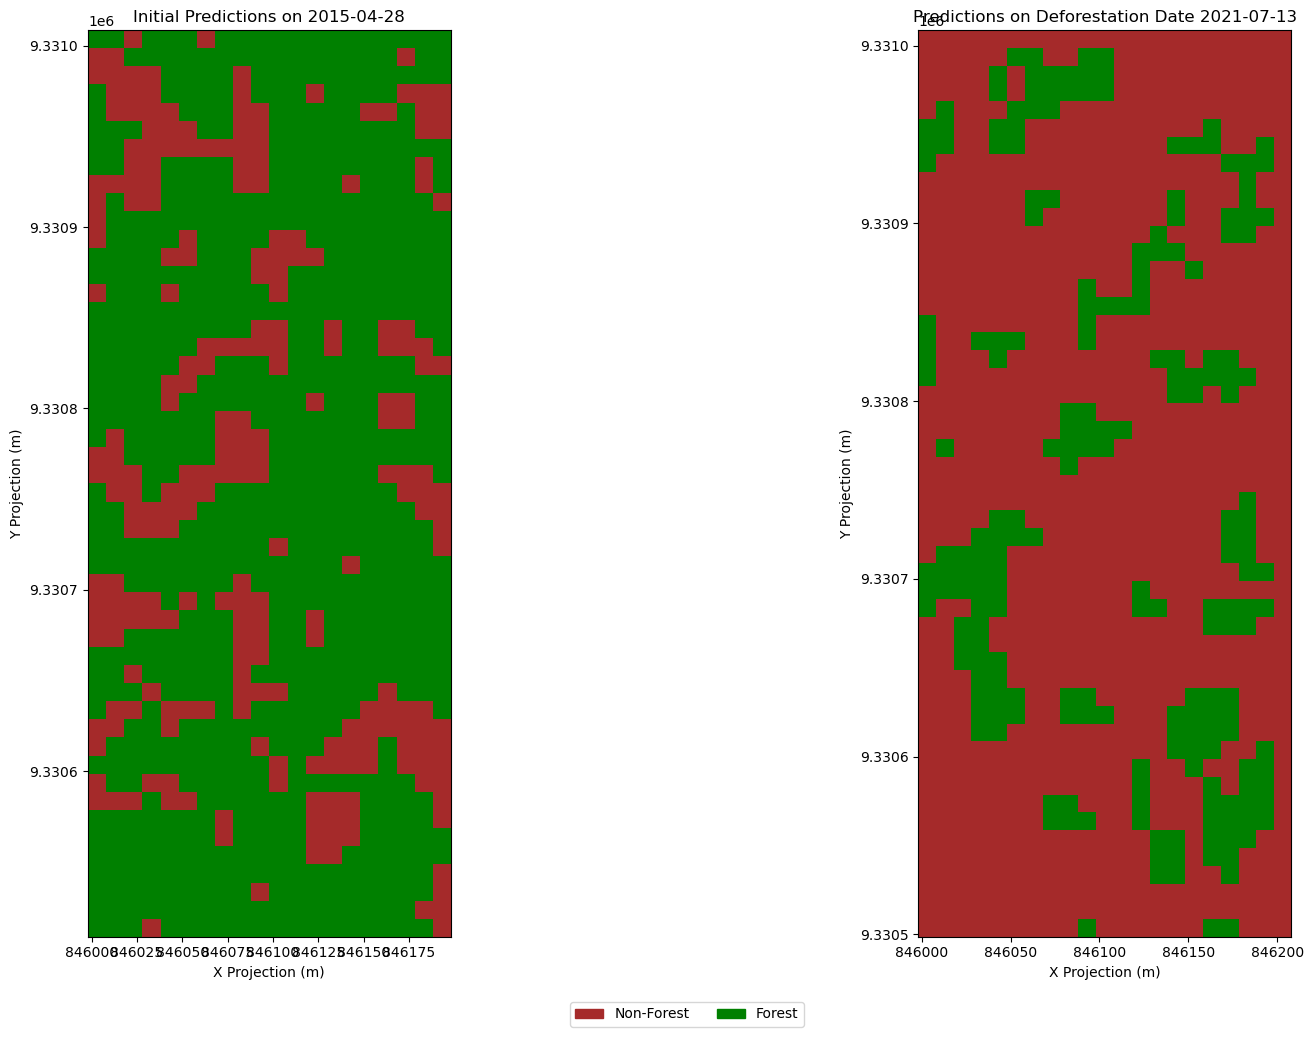

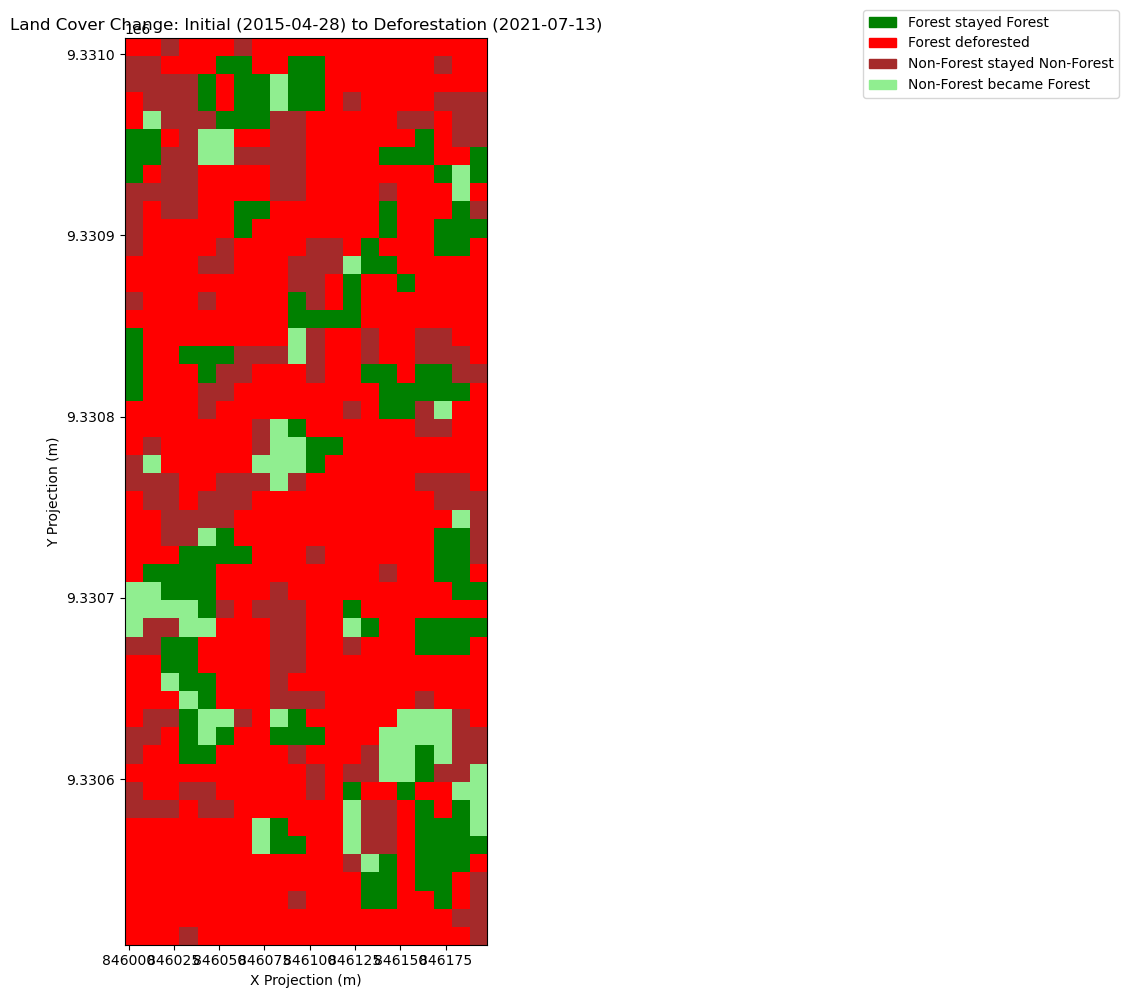

Processing file 186 out of 241...Rate of Change: -12.044817927170868, Exceeds Threshold: False
Processing file 187 out of 241...Rate of Change: 5.228758169934636, Exceeds Threshold: False
Processing file 188 out of 241...Rate of Change: 2.614379084967325, Exceeds Threshold: True
Processing file 189 out of 241...Rate of Change: 0.5602240896358666, Exceeds Threshold: True
Processing file 190 out of 241...Rate of Change: -3.734827264239044, Exceeds Threshold: False
Processing file 191 out of 241...Rate of Change: 17.83380018674137, Exceeds Threshold: True
Processing file 192 out of 241...Rate of Change: 3.828197945844991, Exceeds Threshold: True
Processing file 193 out of 241...Rate of Change: -29.038281979458446, Exceeds Threshold: False
Processing file 194 out of 241...Rate of Change: 27.450980392156865, Exceeds Threshold: True
Processing file 195 out of 241...Rate of Change: 6.4425770308123305, Exceeds Threshold: True
Processing file 196 out of 241...Rate of Change: 0.09337068160597539

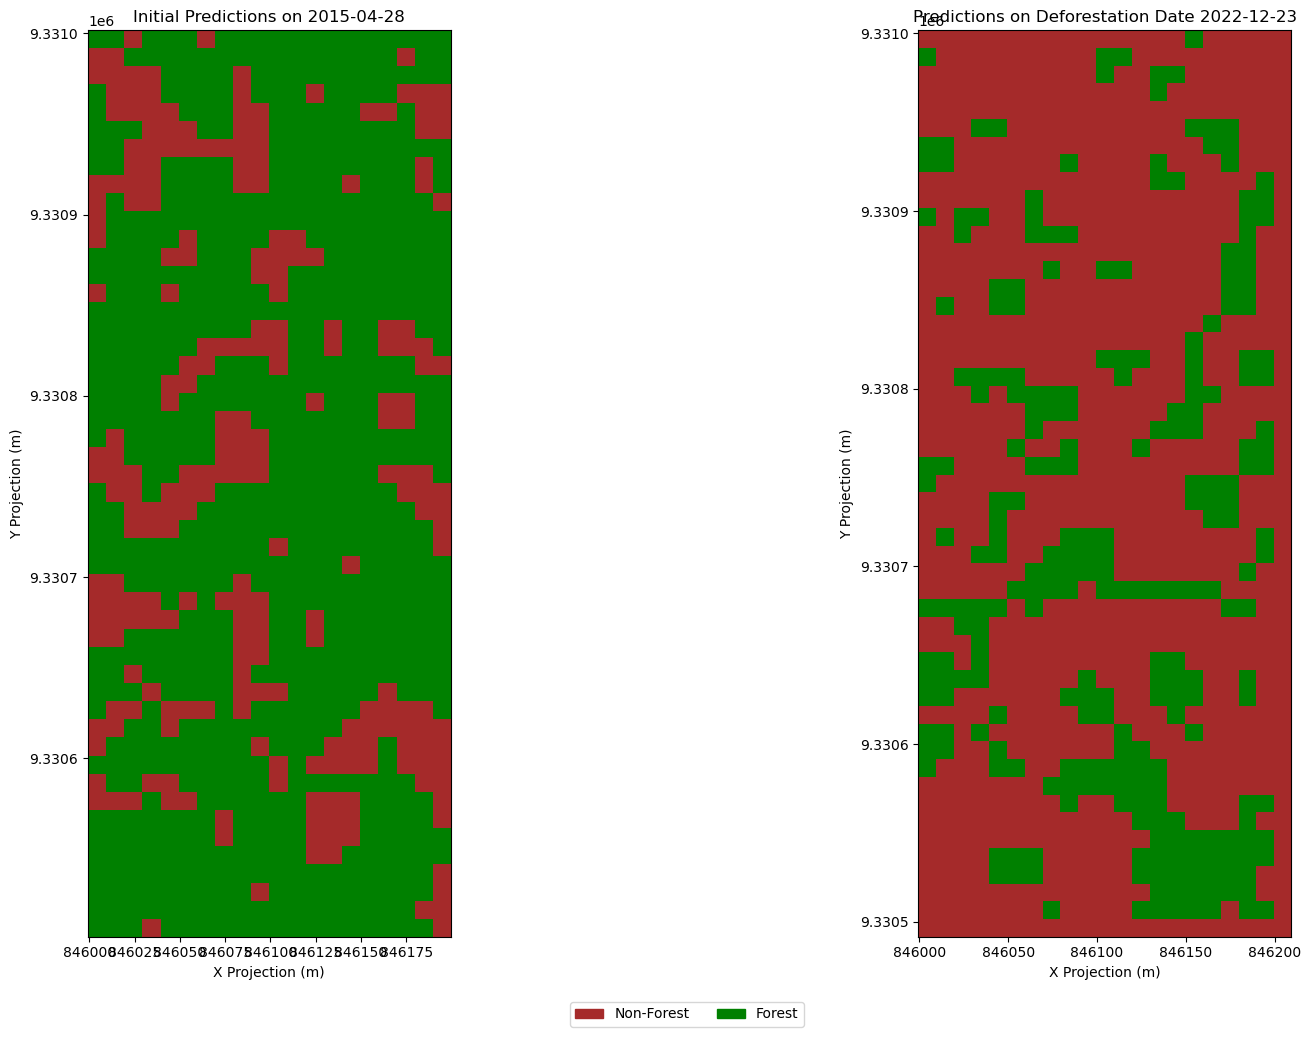

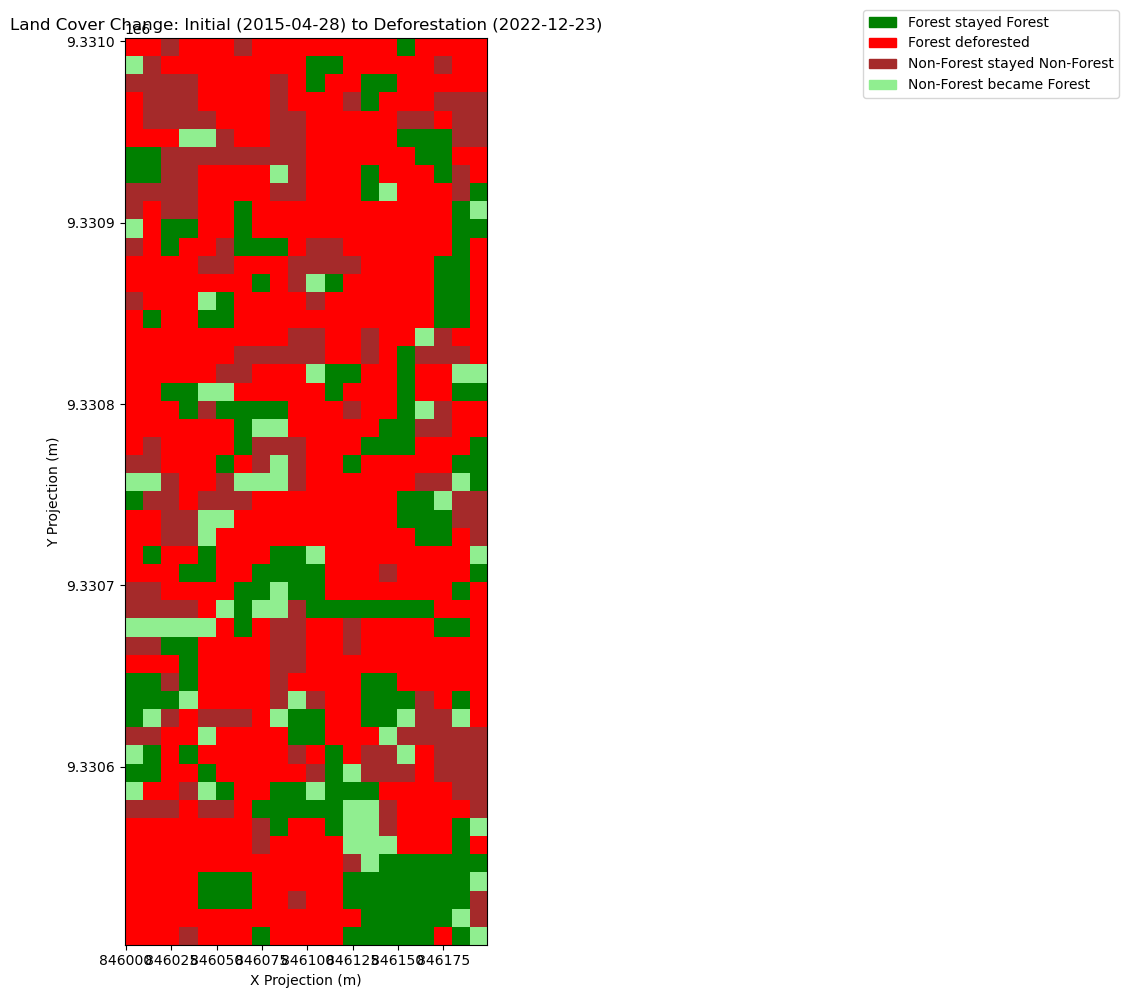

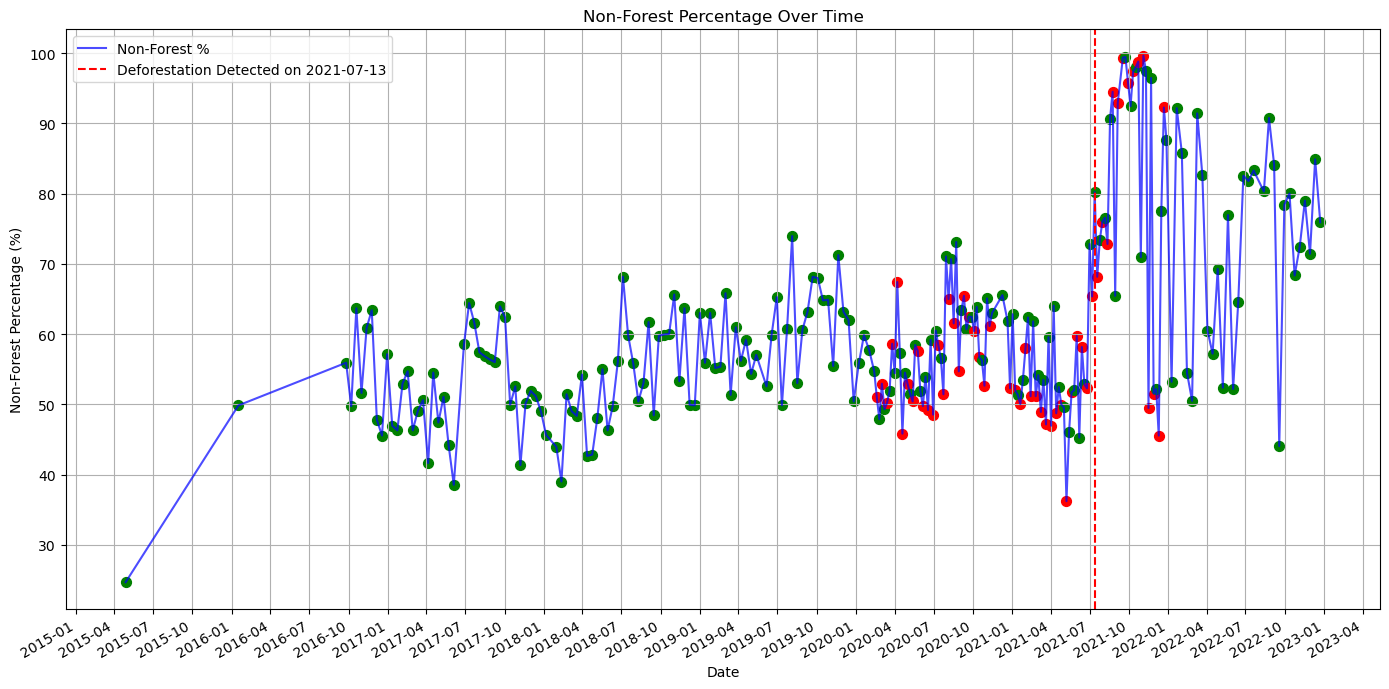


Deforestation detected on: 2021-07-13


In [4]:
# Run the detection function with the combination method
classify_and_detect_deforestation(gdf, tif_files, method='combination')